# Ensemble Learning

Suppose you ask a complex question to thousands of random people. Then, you aggregate their answers. In many cases you will find that this aggregated answer is better than an expert's answer. This is called the _wisdom of the crowd_. Similarly, if you aggregate the predictions of a group of predictors, you will often get better predictions than with the best individual predictor. 

A group of predictors is called __ensemble__; thus, this technique is called _Ensemble Learning_, and an Ensemble Learning algorithm is called an _Ensemble Method_.

# Random Forest
For example, you can train a group of DEcision Tree clasisfiers, each on a different random subset of the training set. To make predictions, you just obtain the predictions of all invdividual trees, then predict the class that gets the most votes. Such an ensembles of Decision Trees is called __Random Forest__. 

## Voting Classifiers
Suppose you have a couple of classifiers such as Logistic Regression classifier, an SVM classifier, a Random Forest classifier, a K-Nearest Neighbors classifier, and perhaps a few more. A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the _most vote_. This majority-vote classifer is called a __hard voting__ classifier.

Even if each classifer is a weak learner, the ensemble can still be a strong learner, provided there are a sufficient number of weak learners and they are sufficiently diverse.

In [1]:
from __future__ import division, print_function, unicode_literals
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
rc('text', usetex = True)
rc('font', family='serif')

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise = 0.3, random_state=42) 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [2]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.888
VotingClassifier 0.888


While __hard voting__ takes the maximum probability of all indivudual classifiers, we could use __soft voting__ which takes the average over all estimates of ensembles. This is called __soft voting__.

In [3]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)
voting_clf_soft = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)
for clf in (log_clf, rnd_clf, svm_clf, voting_clf_soft):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.888
VotingClassifier 0.928


## Bagging and Pasting

One way for ensemble learing is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. When sampling is performed with replacement, this method is called _bagging_ (bootstrap aggregating). When sampling is performed without replacement, it is called _pasting_. If you want to have a __bagging__ classifier, you need to set the hyperparameter __bootstrap__ as __True__. 

In [45]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

beg_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)

beg_clf.fit(X_train, y_train)
y_pred = beg_clf.predict(X_test)

The __BeggingClassifier__ automatically performs soft voting instead of hard voting if he base classifier can estimate class probabilities (i.e. it has a __predict_proba()__ method).

In [46]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.904

## Out-of-Bag Evaluation

By default a __BaggingClassifer__ samples $m$ training instances with replacement (__bootstrap = True__), where $m$ is the size of training set. This means that only $\%63$ of the training instances are sampled on average for each predictor. Thsi is beacuse $1 - (1 - \frac{1}{m})^m = 1 - e^{-1} = \frac{2}{3}$. 
The remaining $\%37$ of the training instanes that are not sampled are called _out-of-bag_ (oob) instances. As the oob instances never be seen during the training, it can be evaluated without the need for a separate validation set or cross-validation. __oob_score=True__ when creating a __BaggingClassifier__. 

In [63]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [64]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

The decision function for each training instance is also available through the __oob_decision_function___ variable.

In [65]:
bag_clf.oob_decision_function_[0:10]

array([[0.34196891, 0.65803109],
       [0.36898396, 0.63101604],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.00546448, 0.99453552],
       [0.07486631, 0.92513369],
       [0.34391534, 0.65608466],
       [0.01595745, 0.98404255],
       [0.98305085, 0.01694915],
       [0.98351648, 0.01648352]])

In [66]:
len(bag_clf.oob_decision_function_) / 2 / len(y)

0.375

## Random Pathces and Random Subspaces

The __BaggingClassifier__ class supports sampling the features, too. This is controlled by two hyperparameters: __max_features__ and __bootstrap_features__. Therefore, each predictor will be  trained on a random subset of input features. Sampliong both training instances and features is caled the __Random Patches__ method. 

Keeping all training instances (i.e., __bootstrap = False__ and __max_samples = 1.0__) but sampling features __bootstrap_features=True__ and __max_features__ smaller than 1.0 is called __Random Subspaces__ method.

In [79]:
beg_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=1000,
    max_samples=0.6, bootstrap=True, n_jobs=-1,
    max_features=0.8, bootstrap_features=True
)
beg_clf.fit(X_train, y_train)
y_pred = beg_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.848

## Random Forest

As we have discussed, a __Random Forest__ is an ensemble of Decision Trees, generally trained via the bagging method. 

In [81]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

accuracy_score(y_pred_rf, y_test)

0.904

The random Forest Algorithm introduces extra randomness when growing trees. Instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features.

### Extra Trees

When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting. It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds. This forest is called __Extremely Randomized Trees ensemble__ (__Extra-Trees__ for short). You can use __Scikit-Learn's ExtraTreesClassifier__ class. 

### Feature Importance

Yet another quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature's importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node's weight is equal to the number of training samples that are associated with it. 

In [84]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09769289171103963
sepal width (cm) 0.024663399971489423
petal length (cm) 0.4205228415850102
petal width (cm) 0.4571208667324614


In [87]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [88]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [123]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap='RdYlGn_r', interpolation='nearest')
    plt.axis('off')
    return

In [124]:
mnist.data.shape

(70000, 784)

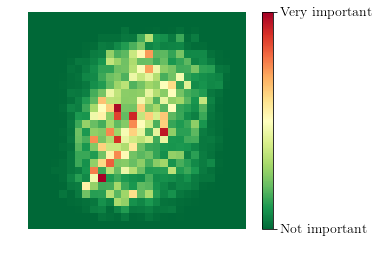

In [125]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

# Boosting

## Ada Boost

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor misclassified. In AdaBoost algorithm, each instance weight $w^{(i)}$ is initially set to $\frac{1}{m}$. The weighted error rate $j^{th}$ predictor's prediction is computed as follows:
$$r_j = \frac{\sum_{i=1, \hat{y}^{(i)} \neq y^{(i)}}^{m}{w^{(i)}}}{\sum_{i=1}^{m}{w^{(i)}}}$$
The predictor's weight $\alpha_j$ is then computed using $\alpha_j = \eta \log{\frac{1 - r_j}{r_j}}$, where $\eta$ is the learning rate (defaults to $1$). The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to __zero__. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be __negative__ (will be doing the opposite things).

Next, the instance weights are updated so that the misclassified instances are boosted.
__for__ $ i = 1, 2, \cdots, m$
$$
w^{(i)} =  
\Bigg\{
    \begin{array}{}
      w^{(i)} & \text{ if }  \hat{y}^{(i)} = y^{(i)}\\
      w^{(i)} e^{(\alpha_j)} & \text{ if }  \hat{y}^{(i)} \neq y^{(i)}\\
    \end{array} 
$$

Then, all instance weights are normalized (i.e. divided by $\sum_{i=1}^{m}{w^{(i)}}$)

To make predictions, __AdaBoost__ simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes. 

$\hat{y}(x) = \max_k \sum_{j = 1, \hat{y}_j(x)=k}^{N}{\alpha_j}$, where $N$ is the number of predictors. 

In [145]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.896

## Gradient Boosting

Another very popular boosting algorithm is __Gradient Boosting__. Like __AdaBoost__, __Gradient Boosting__ works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance at every iteration like __AdaBoost__ does, this method tries to fit the new predictor to the __residual error__ made by the previous predictor. 

Let's go through a simple regression example using __Decision Trees__ as the base predictors (of course _Gradient Boosting_ also works great with regression tasks). This is called __Gradient Tree Boosting,__ or __Gradient Boosted Regression Trees (GBRT for short)__. 

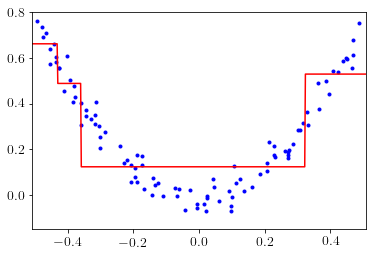

In [186]:
def plot_predictions(regressors, X, y, axes):
    x_test = np.linspace(axes[0], axes[1], 500)
    y_test_pred = sum(regressor.predict(x_test.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X, y, 'b.')
    plt.plot(x_test, y_test_pred, 'r-')
    plt.axis(axes)

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0]**2 + 0.05 * np.random.randn(100)

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)
plot_predictions([tree_reg1], X, y, [-0.51, +0.51, -0.15, 0.8])

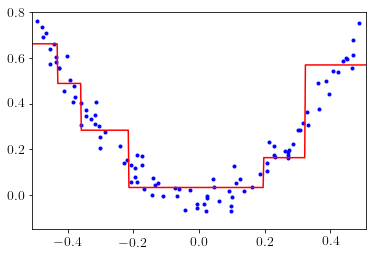

In [187]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)
plot_predictions([tree_reg1, tree_reg2], X, y, [-0.51, +0.51, -0.15, 0.8])

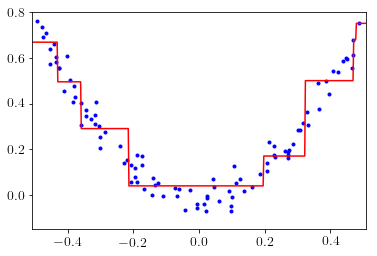

In [188]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, [-0.51, +0.51, -0.15, 0.8])

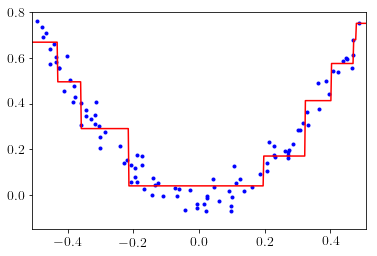

In [189]:
y4 = y3 - tree_reg3.predict(X)
tree_reg4 = DecisionTreeRegressor(max_depth=2)
tree_reg4.fit(X, y4)
plot_predictions([tree_reg1, tree_reg2, tree_reg3, tree_reg4], X, y, [-0.51, +0.51, -0.15, 0.8])

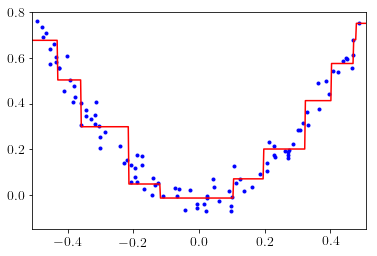

In [190]:
y5 = y4 - tree_reg4.predict(X)
tree_reg5 = DecisionTreeRegressor(max_depth=2)
tree_reg5.fit(X, y5)
plot_predictions([tree_reg1, tree_reg2, tree_reg3, tree_reg4, tree_reg5], X, y, [-0.51, +0.51, -0.15, 0.8])

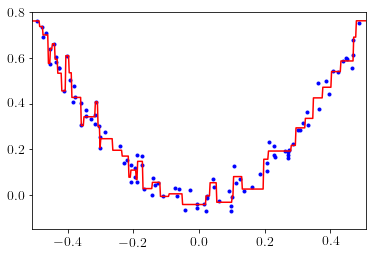

In [204]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=20, learning_rate=1.0)
gbrt.fit(X, y)
plot_predictions([gbrt], X, y, [-0.51, +0.51, -0.15, 0.8])